In [3]:
# change directory to parent for local imports
import os
os.chdir('..')
print(os.getcwd())

/nfs/git/InteractiveInference/src/hello_world


In [549]:
import importlib

import jax
import jax.numpy as jnp
jax_rng = jax.random.PRNGKey(1337)

import numpy as np
np_rng = np.random.default_rng(1337)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # show_p_s()
from tqdm import tqdm

import minimal_agent_jax as jax_agents
import mountain_car_environment as envs

%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri Mar 31 2023

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.11.0

jax       : 0.4.8
numpy     : 1.23.5
matplotlib: 3.7.1

Watermark: 2.3.1



In [550]:
def jax_fully_observed_nefe(π_logits, q, p_t, log_p_c):
    """ Deterministic policy selection with pragmatic value in fully-observed environment.
    Args:
        num_actions (int): number of unique actions. Jit assumes this is static across calls.
        q (jnp.ndarray): one-hot encoding of the observed state
        πs (jnp.ndarray): 4D tensor of one-hot actions [batch, policy, timestep, one_hot_action].
        p_t (jnp.ndarray): 3D tensor of transition dynamics [a, s0, s1].
        log_p_c (jnp.ndarray): 1D tensor of normalized state preferences. One element per environment state.
    """

    def step(q, a):
        q = a @ (q @ p_t)
        return q, q
    
    # calculate nefe
    π = jax.nn.softmax(π_logits)
    qs_π = jax.lax.scan(step, init=q, xs=π)[1] # carry, output
    pragmatic = (qs_π @ log_p_c).sum(axis=-1)
    nefe = pragmatic
    return nefe

def jax_update(π_logits, q, p_t, log_p_c, lr):
    eval_fun = jax.value_and_grad(jax_fully_observed_nefe)
    v, g = eval_fun(π_logits, q, p_t, log_p_c)
    π_logits = π_logits + lr * g
    return v, π_logits

#embed function into agent
class FullyObservedGradAgentJax:
    """ Minimal agent performing exact inference in fully discrete POMDPs"""
    def __init__(self, 
                 env,
                 target_state, 
                 k=2, 
                 num_grad_steps=100, 
                 learning_rate=2.):
        self.env = env
        self.target_state = target_state
        self.k = k
        self.p_t = jnp.asarray(env.p_s1_given_s_a.swapaxes(0,1))
        self.num_gradient_steps = num_grad_steps
        self.learning_rate = learning_rate
        
    def reset(self):
        # initialize state preference
        q_star = np.eye(self.env.s_N)[self.target_state] * 10
        self.log_p_c = jnp.log( jnp.exp( q_star ))
    
    def step(self, o, debug=True):
        π_logits = jnp.zeros( (self.k, self.env.a_N) ) # initialize uniform
        params = {
            'q': jax.nn.one_hot(o, self.env.s_N),
            'p_t': self.p_t,
            'log_p_c': self.log_p_c,
            'lr': self.learning_rate
        }
        vv = []
        for _ in range(self.num_gradient_steps):
            v, π_logits = jax.jit(jax_update)(π_logits, **params)
            vv.append(v)
        
        π = π_logits.argmax(axis=-1)
        return π, vv, π_logits if debug else π

In [546]:
importlib.reload(jax_agents)
importlib.reload(envs)

k = 32 # planning time horizon
s_target = np.array([1., 0.]) # specify target state as continuous [position, velocity]
env = envs.MountainCarDiscrete()
agent = jax_agents.FullyObservedGradAgentJax(env=env, 
                                  target_state=env.index_s_from_s(s_target), 
                                  k=k,
                                  num_grad_steps=10, 
                                  learning_rate=1e2)
agent.reset()

ss = [env.reset()]
ππ = []
vvv = []
ππ_logits = []
for t in tqdm(range(k)):
    π, vv, π_logits = agent.step(ss[-1], debug=True)
    vvv.append(vv)
    ππ_logits.append(π_logits)
    ππ.append(π)
    ss.append(env.step(ππ[-1][0]))

JAX devices: [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]
JAX device type: NVIDIA RTX A6000
Loading transition dynamics from file "mountain_car_transition_dynamics.npy"


100%|██████████| 32/32 [00:02<00:00, 13.54it/s]


Text(0.5, 0.98, 'Observed trajectory')

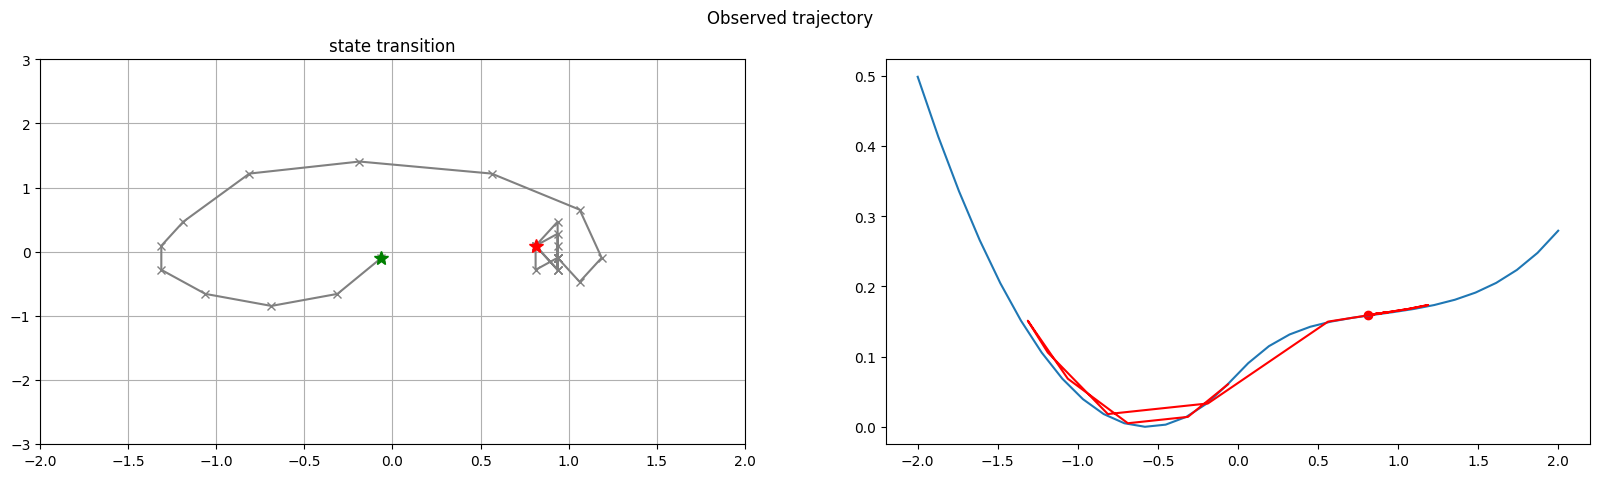

In [ ]:
env.plot_trajectory(ss, color='gray', legend=False if r>0 else True)
plt.suptitle('Observed trajectory')

Text(0, 0.5, 'q(a)')

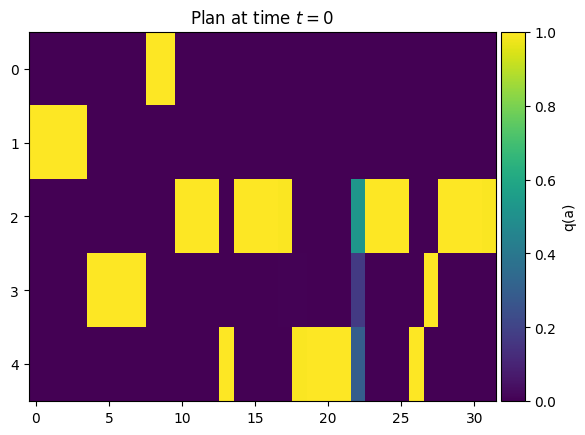

In [551]:
def show_q_a(π_logits):
    q_π = jax.nn.softmax(π_logits)
    aa = q_π.argmax(axis=-1)
    im = plt.imshow(q_π.T, aspect='auto', vmin=0, vmax=1)

    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.title('Plan at time $t=0$');
show_q_a(ππ_logits[0])
plt.ylabel('q(a)')

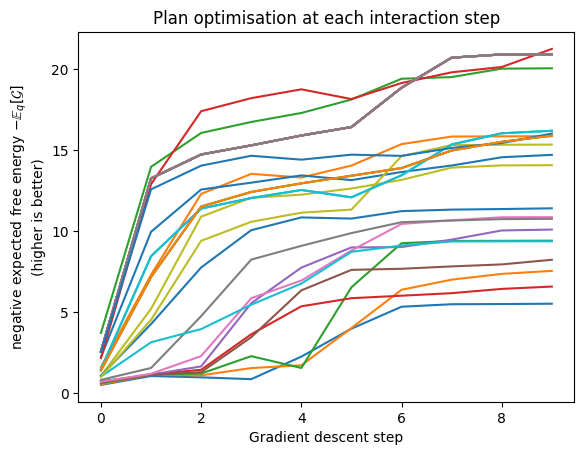

In [552]:
for t, vv in enumerate(vvv):
    plt.plot(vv, label=f'{t}')
    
plt.title('Plan optimisation at each interaction step');
plt.xlabel('Gradient descent step');
plt.ylabel('negative expected free energy $-\mathbb{E}_{q}[ \mathcal{G} ]$\n(higher is better)');
#plt.legend();

In [ ]:
# what would happen if we followed the same sequence of actions in an alternate sequence of sampled state transitions?
n_rollouts = 16
π = [π[0] for π in ππ]

fig, ax = plt.subplots(1,2 , figsize=(2*8, 6))
ax[0].scatter([s_target[0]], [s_target[1]], color='r', marker='o', s=10**2, label='target', zorder=1)
for r in range(n_rollouts):
    ss = [env.reset()]
    for a in π:
        ss.append(env.step(a))

    env.plot_trajectory(ss, ax=ax, color='gray', legend=False if r>0 else True)

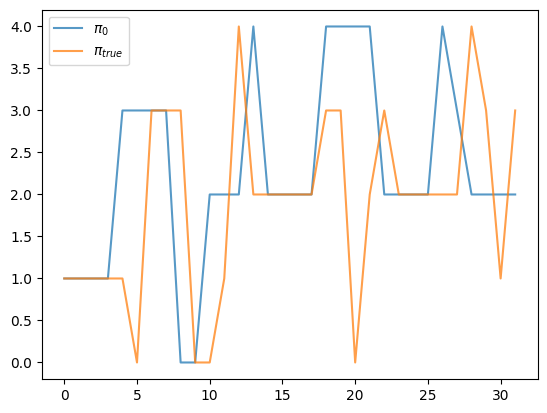

In [554]:
π_0 = ππ[0] # original plan
π_true = [π[0] for π in ππ] # selected actions
plt.plot(π_0, label='$π_0$', alpha=0.75);
plt.plot(π_true, label='$π_{true}$', alpha=0.75);
plt.legend()